# Stock market forecasting using sequential neural net model

- The goal is to build and train a model using five years of stock market data. We will then use the trained model to predict out five days into the future using live data. 


- The dataset that is being used is obtained from kaggle. This dataset has all the SP500 companies aggregated into one csv file which we will use train on.


- It is important to notice that this is a forecasting model instead of predicting model. Predicting the stock market is quite difficult which require usually a lot more data. 


- Predictive strategies are usually less than 60% accurate, but its enough for hedge funds to capitalise on them using leverage. 

In [118]:
#import all the neccessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
import datetime, random
import numpy as np; np.random.seed(0)
import warnings
import itertools
import numpy as np
import pandas_datareader.data as web
warnings.filterwarnings('ignore')


In [119]:
#load the csv file
stocks_df=pd.read_csv('all_stocks_5yr.csv')
stocks_df

,date,open,high,low,close,volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM
...,...,...,...,...,...,...,...
606796,2017-08-07,62.12,62.34,61.25,61.83,4208287.0,ZTS
606797,2017-08-08,60.49,61.00,59.50,60.00,4663668.0,ZTS
606798,2017-08-09,59.95,60.87,59.76,60.81,4017297.0,ZTS
606799,2017-08-10,60.87,61.37,59.71,59.74,2690725.0,ZTS


In [120]:
#check the date ranges
print(str('Earliest date: '+np.min(stocks_df['date'])))
print(str('Latest date: '+np.max(stocks_df['date'])))

Earliest date: 2012-08-13
Latest date: 2017-08-11


In [121]:
#Check how many symbols we have
print(str('Total symbols: '+str(len(set(stocks_df['Name'])))))

Total symbols: 503


In [123]:
stocks_df.describe()

,open,high,low,close,volume
count,606417.000000,606593.000000,606574.000000,606801.000000,6.063950e+05
mean,79.529041,80.257435,78.799338,79.557920,4.500925e+06
std,93.383162,94.187977,92.535300,93.382168,9.336171e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,38.070000,38.460000,37.700000,38.090000,1.077091e+06
50%,59.240000,59.790000,58.690000,59.270000,2.131913e+06
75%,89.390000,90.150000,88.620000,89.430000,4.442768e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


- It is always good to see how the data looks beforehand just to check if there are any anomalies  we should look into. We can see that min stock value is 1.62 whereas the max is 2044. Looking at this we may have to normalise the data when training

In [124]:
stocks_df.shape

(606801, 7)

No handles with labels found to put in legend.


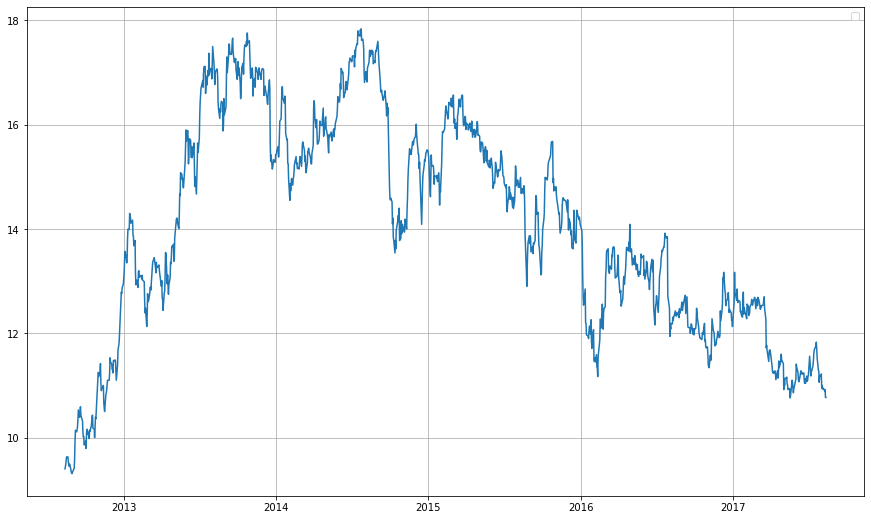

In [125]:
# Quick visualisation 

#plot Ford stock by itself
temp_df=stocks_df[stocks_df['Name']=='F']
#set index to date
temp_df=temp_df.set_index(temp_df['date'])


plt.subplots(figsize=(15,9))
#dont forget to set date to datetime for better quality plotting
plt.plot(pd.to_datetime(temp_df['date']),temp_df['close'])
plt.grid()
plt.legend(loc='best')


No handles with labels found to put in legend.


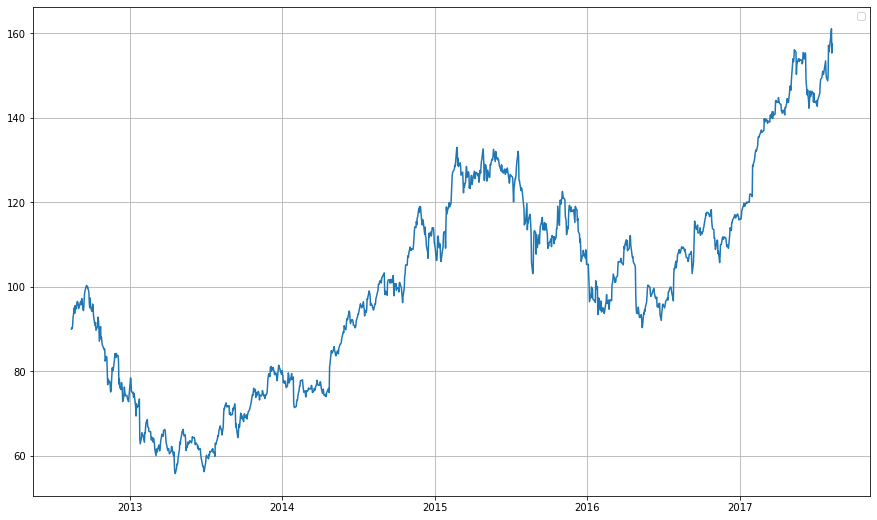

In [126]:
#plot Ford stock by itself
temp_df2=stocks_df[stocks_df['Name']=='AAPL']
#set index to date
temp_df2=temp_df2.set_index(temp_df['date'])


plt.subplots(figsize=(15,9))
#dont forget to set date to datetime for better quality plotting
plt.plot(pd.to_datetime(temp_df2['date']),temp_df2['close'])
plt.grid()
plt.legend(loc='best')

# The Plan

- It is imperative that we take the consecutive data as this is a time series data hence the order at which the price moves is of high importance.


- The main theory behind this forecasting model is the assumption that markets are always in a trend. If today is an up day then tomorrow is more likely to be an upday and vice versa. 


- As mentioned before the goal is to forecast individual stocks five days in the future. We will do this by taking 10 consecutive trading days of a given stock and forecast 5 days out.


- We will give the model 10 days of trading data to analyse the trend in the data and forecast out accordingly.


# Normalizing 

- In order to present the relationship between the data points more accurately, we will normalize the data. Normalizing will help the model learn better as large stock values will not skew the data when forecasting.  


- We will use log transform for this case as its simple to use, we could also use Min Max scalar from sklearn to normalize the data also.


- The log transform mainly clumps the data points closer together (by putting them on a log scale) so that there aren't any big variation in the dataset which may confuse the model.



In [127]:
#get stock data
stock_data=stocks_df[stocks_df['Name']=='KSU']

d=np.log(stock_data[['close']])
d.head()

,close
322632,4.303930
322633,4.322542
322634,4.333624
322635,4.338597
322636,4.353756


# Getting the data ready for the model

## Feature engineering

- We will be separating out the data into features and labels or x and y. 


- What we will be doing is taking the first 10 consecutive price values and saving them into x list, we will then take the following five consecutive values and save them into y list. We will keep iterating down by one increment until we get to end of dataset.  We will do this for each stock symbol.




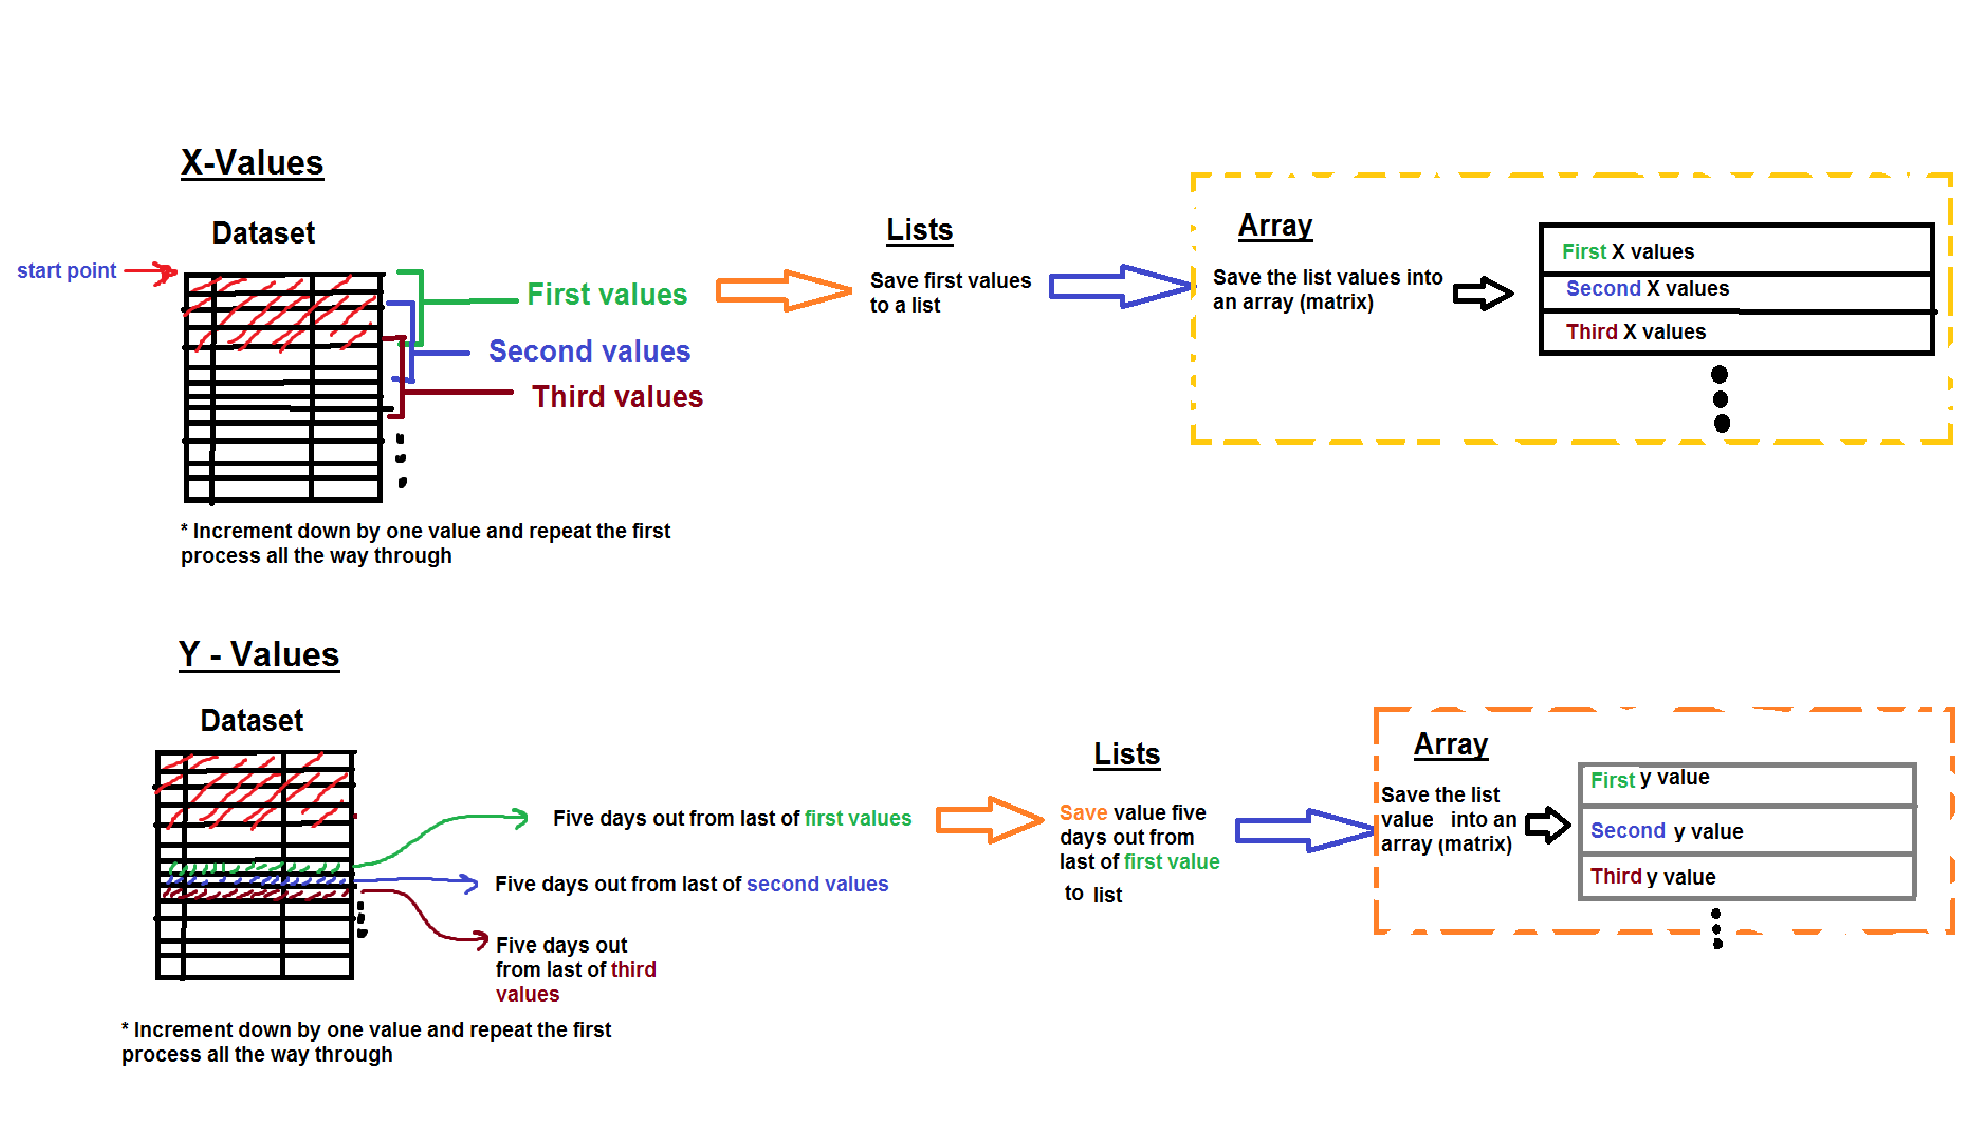

In [128]:
from IPython.display import Image
Image(filename='Process.png')

In [129]:
#Have all the stock symbols ready
stock_symbols = list(set(stocks_df['Name']))
stock_symbols

['ATVI',
 'HRS',
 'VLO',
 'ES',
 'DUK',
 'JNJ',
 'MDLZ',
 'MAS',
 'PEP',
 'ADI',
 'LUV',
 'NYSE:LMT',
 'ALLE',
 'PCG',
 'BAC',
 'NSC',
 'L',
 'HBAN',
 'COG',
 'SIG',
 'INTC',
 'GOOGL',
 'FTV',
 'MCHP',
 'MRK',
 'CAH',
 'WU',
 'MMM',
 'CB',
 'FAST',
 'SNPS',
 'MNST',
 'O',
 'AFL',
 'VNO',
 'CVS',
 'AIZ',
 'FB',
 'MHK',
 'FOXA',
 'TJX',
 'WYNN',
 'ECL',
 'SYF',
 'CNC',
 'AEP',
 'UAA',
 'ABC',
 'GS',
 'WM',
 'SBUX',
 'ACN',
 'ADS',
 'OKE',
 'FFIV',
 'LH',
 'MSI',
 'GOOG',
 'MYL',
 'PX',
 'STI',
 'EW',
 'ALL',
 'BRK.B',
 'PSX',
 'ALGN',
 'COTY',
 'TSCO',
 'JBHT',
 'NAVI',
 'YUM',
 'FTI',
 'DISCA',
 'HIG',
 'NUE',
 'ILMN',
 'CCL',
 'COF',
 'FLS',
 'PM',
 'HCN',
 'TGT',
 'EVHC',
 'DFS',
 'BSX',
 'MCK',
 'BXP',
 'CHRW',
 'ETR',
 'ISRG',
 'APH',
 'BAX',
 'JNPR',
 'K',
 'FRT',
 'HOG',
 'CA',
 'HRL',
 'PPG',
 'AAPL',
 'LUK',
 'NWSA',
 'DVN',
 'GT',
 'APD',
 'IT',
 'DTE',
 'AZO',
 'CME',
 'LNC',
 'DGX',
 'LEG',
 'WMT',
 'AIG',
 'ANTM',
 'MU',
 'NVDA',
 'TIF',
 'AON',
 'ARE',
 'LOW',
 'M',
 'PEG',

In [130]:
# Get the empty lists ready to populate values and symbols in them 
X = []
y = []
symbols = []
prediction_dates = []
last_market_dates = []

- We will iterate though each symbol separately  as we do not want to mix the stock data (we can't use TSLA data to forecast MSFT data) 

- Also we will not use the last 5 data point in the dataset 

##### The X Values
- Save 10 values at a time and increment down by one and repeat process, until we get to the bottom of the dataset

##### Y values 
- Save the 15th value in dataset( 5 days out from first 10 consecutive days) and keep incrementing down by one and saving the value into array until we reach end of dataset. 

##### Quick check
- We can view the X and Y value to see how the data has been stored into array. The 15th multiple of the X value should be present on the Y values

In [131]:

#Following the process outlined above we will split the data into X and y values


# rolling predictions
rolling_period = 10
predict_out_period = 5


# iterate through each stock and carry out operations

#pull out individual stock data from the csv file
for stock in stock_symbols:
    print(stock)
    stock_data = stocks_df[stocks_df['Name']==stock].copy()
    
    #for that individual stock number take the 10th value (10,3000-10)
    for per in range(10, len(stock_data)-5):
        X_tmp = []
        #(0,10)
        #
        for rollper in range(per-10,per):
            # build the 'features'
            #apply the log transform
            #first 10 values populated to list
            X_tmp += [np.log(stock_data['close'].values[rollper])]
        #first 10 values populated into array
        X.append(np.array(X_tmp))
        
        # build 'labels'
        # add the 15th value of the close data for every 10 values, into y
        y.append(np.log(stock_data['close'].values[per + 5]))
        # add the 15th date value for every 10 dates, into prediction_dates
        prediction_dates.append(stock_data['date'].values[per + 5])
        #add each date between the 10th value to end of dataset(excluding last 5 days)
        last_market_dates.append(stock_data['date'].values[per])
        symbols.append(stock)

ATVI
HRS
VLO
ES
DUK
JNJ
MDLZ
MAS
PEP
ADI
LUV
NYSE:LMT
ALLE
PCG
BAC
NSC
L
HBAN
COG
SIG
INTC
GOOGL
FTV
MCHP
MRK
CAH
WU
MMM
CB
FAST
SNPS
MNST
O
AFL
VNO
CVS
AIZ
FB
MHK
FOXA
TJX
WYNN
ECL
SYF
CNC
AEP
UAA
ABC
GS
WM
SBUX
ACN
ADS
OKE
FFIV
LH
MSI
GOOG
MYL
PX
STI
EW
ALL
BRK.B
PSX
ALGN
COTY
TSCO
JBHT
NAVI
YUM
FTI
DISCA
HIG
NUE
ILMN
CCL
COF
FLS
PM
HCN
TGT
EVHC
DFS
BSX
MCK
BXP
CHRW
ETR
ISRG
APH
BAX
JNPR
K
FRT
HOG
CA
HRL
PPG
AAPL
LUK
NWSA
DVN
GT
APD
IT
DTE
AZO
CME
LNC
DGX
LEG
WMT
AIG
ANTM
MU
NVDA
TIF
AON
ARE
LOW
M
PEG
LEN
KO
CHK
PGR
MDT
FLR
MS
AET
EXPE
COL
FBHS
GLW
EMR
WHR
DPS
IRM
PWR
NEE
SWKS
HUM
VRTX
KEY
PDCO
KMB
CSX
PYPL
BA
BLL
IVZ
VZ
BIIB
CTL
PFE
TSN
VRSK
VMC
CSCO
ABT
GWW
CVX
MAA
XL
PCAR
XLNX
CTXS
EXR
AMGN
GGP
NOV
AOS
AWK
BHF
IBM
CFG
D
SLG
VTR
KMI
BWA
UPS
FL
AJG
MO
KMX
NTAP
AGN
NFX
INFO
HP
PFG
EXC
JPM
PHM
CNP
UNP
DAL
CMS
MTB
EQT
RF
ADM
UNH
USB
EBAY
EIX
ALB
FMC
HON
UA
IPG
FITB
WFC
RMD
RJF
HCP
ROST
BCR
DXC
SYMC
HAS
PAYX
MGM
AVY
DLPH
MLM
IDXX
ZTS
PBCT
FDX
SLB
BBT
STZ
HST
MCO
PVH
COST
ROP
QCOM
ADBE
G

#### The for loop

- In order to create the dataset accordingly we have used multiple nested loops to separate out the required values in chunks.


### Steps

###### first 
- First we start with a a given stock.

###### second 

- The second loop outlines the rounds of which we will iterate through the data. The main guide for this is the 'per' variable

- At the end the last "per" value should be equal to the number of rows in final dataset

###### third 

- The third loop 'rollper', loops through 10 values (in the iterables bracket) at every round. 

- It adds each value to the X_tmp list until it reaches the last iterable.

##### Lastly 

- We break out from the third loop and then turn the 10 values stored in x_tmp list to an array.

- We add the y_label value to the y list using 'per' as a guide to indicate the last market value with the addition of 5 (since we want the 5 days out value)

- Similarly, we append the y_label date to the prediction_date list using 'per +5'

- We then append the stock symbol to symbol list and we restart from the second loop and go to the next iteration and repeat the whole process. Once we iterate through all the values whilst populating the lists in that given stock,  we will break out from the second loop and move to the first loop in order to go to the next stock symbol. Again, we will repeat the entire  processes until get to the very end of the stock symbols lists.

#### Tips

- For every round 'per' is always the indicator to the last market value for each round

- For every round 'rollper' iterables are the 10 values that get passed along one by one to the X_tmp (in the third loop)

### Combine everything into a single dataframe


In [132]:
#Pass the X values to df
stock_model_ready_df = pd.DataFrame(X)

#stock_model_ready_df.columns = [str(f) for f in list(stock_model_ready_df)]

#Add the rest of the lists into dataframe
stock_model_ready_df['outcome'] = y
stock_model_ready_df['prediction_date'] = prediction_dates
stock_model_ready_df['last_market_date'] = last_market_dates
stock_model_ready_df['symbol'] = symbols
stock_model_ready_df.head(20)


#stock_model_ready_df1=stock_model_ready_df.to_csv('stock_model_ready.csv')

,0,1,2,3,4,5,6,7,8,9,outcome,prediction_date,last_market_date,symbol
0,2.444085,2.444952,2.452728,2.474856,2.493205,2.483239,2.476538,2.468100,2.461297,2.463853,2.457878,2012-09-04,2012-08-27,ATVI
1,2.444952,2.452728,2.474856,2.493205,2.483239,2.476538,2.468100,2.461297,2.463853,2.460443,2.469793,2012-09-05,2012-08-28,ATVI
2,2.452728,2.474856,2.493205,2.483239,2.476538,2.468100,2.461297,2.463853,2.460443,2.463853,2.503892,2012-09-06,2012-08-29,ATVI
3,2.474856,2.493205,2.483239,2.476538,2.468100,2.461297,2.463853,2.460443,2.463853,2.467252,2.486572,2012-09-07,2012-08-30,ATVI
4,2.493205,2.483239,2.476538,2.468100,2.461297,2.463853,2.460443,2.463853,2.467252,2.457021,2.483239,2012-09-10,2012-08-31,ATVI
5,2.483239,2.476538,2.468100,2.461297,2.463853,2.460443,2.463853,2.467252,2.457021,2.464704,2.484073,2012-09-11,2012-09-04,ATVI
6,2.476538,2.468100,2.461297,2.463853,2.460443,2.463853,2.467252,2.457021,2.464704,2.457878,2.477378,2012-09-12,2012-09-05,ATVI
7,2.468100,2.461297,2.463853,2.460443,2.463853,2.467252,2.457021,2.464704,2.457878,2.469793,2.484907,2012-09-13,2012-09-06,ATVI
8,2.461297,2.463853,2.460443,2.463853,2.467252,2.457021,2.464704,2.457878,2.469793,2.503892,2.494032,2012-09-14,2012-09-07,ATVI
9,2.463853,2.460443,2.463853,2.467252,2.457021,2.464704,2.457878,2.469793,2.503892,2.486572,2.483239,2012-09-17,2012-09-10,ATVI


- The last market date is the last date value for each X value row.

- The prediction date is the outcome column date

In [133]:
stock_model_ready_df.shape

(599256, 14)

In [134]:
#save the the feature engineered dataset to csv file for later use
stock_model_ready_saved=stock_model_ready_df.to_csv('stock_model_ready.csv',index=False)


### Using Keras library to build regression neural net model

- Keras is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow 2.0 to do numerical modelling. Keras library is able to build many neural net ML solutions such as logistical regression, linear regression, multi-class classification and many more. It is very simple to use and is relatively quick compared to using the raw Tensorflow library. 




### Split the data for training and testing 


-  When building machine learning models we have to be very careful not to mix the feature and label values as the whole model will be completly flawed if we do so.


- We are going to split the dataframe we constructed into three sets --> training, testing and validation


- We will be adding a validation set which will be one full stock symbol that we will separate out from the dataset. The model will no be exposed to this stock symbol at any point. We will use it at the end to see how close the trained model forecasts the stock out.


- We can split the data by date or randomly. For this project we will split the data by date 

In [135]:
#Seperating the feaures from the labels
LABEL = 'outcome'
#remove the necessary columns
FEATURES = [f for f in list(stock_model_ready_df) if f not in [LABEL]]
MODEL_FEATURES = [f for f in list(stock_model_ready_df) if f not in [LABEL, 'prediction_date', 'last_market_date', 'symbol']]

In [136]:
#Features columns (X)
print('Dataset features = ',FEATURES)
print('Dataset model features = ',MODEL_FEATURES)
#Label column (y)
print('Dataset label = ',LABEL)

Dataset features =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'prediction_date', 'last_market_date', 'symbol']
Dataset model features =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Dataset label =  outcome


In [137]:
#stock that we will use for our validation test
val_stock ='MMM'
val_stock_df = stock_model_ready_df[stock_model_ready_df['symbol']==val_stock]

#Remove the validation stock from our dataframe
stock_model_ready_df = stock_model_ready_df[stock_model_ready_df['symbol']!=val_stock]
print('Excluded validation data- removed:', val_stock_df.shape, 'rows and columns')


Excluded validation data- removed: (1243, 14) rows and columns


## Training the model

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split 
# fix random seed for reproducibility
np.random.seed(7)


# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(stock_model_ready_df[FEATURES],
                         stock_model_ready_df[LABEL], test_size=0.33, random_state=42)

model = Sequential()
model.add(Dense(5, activation='relu', input_dim=10))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

 
# Fit the model
model.fit(x_train[MODEL_FEATURES], y_train, epochs=3, batch_size=5, verbose=1)  

Train on 400668 samples
Epoch 1/3
400668/400668 [==============================] - 98s 245us/sample - loss: 0.0231
Epoch 2/3
400668/400668 [==============================] - 98s 244us/sample - loss: 0.0022
Epoch 3/3
400668/400668 [==============================] - 98s 246us/sample - loss: 0.0021


In [140]:
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (400668, 13)
x_test.shape: (197345, 13)
y_train.shape: (400668,)
y_test.shape: (197345,)


In [141]:
# evaluate the model
scores = model.evaluate(x_test[MODEL_FEATURES], y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores*100))


loss: 0.17%


###### Save model

In [142]:
#Save the weights of the model to be used for later

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


###### Load model

In [143]:
from tensorflow.keras.models import model_from_json
# deserialize the model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [144]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
score = loaded_model.evaluate(x_test[MODEL_FEATURES], y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[0], score*100))
 

loss: 0.17%


### Testing on the validation data

In [145]:
val_stock='F'
# predictions have to be restored for processing
validation_tmp = stock_model_ready_df.copy()
#
validation_tmp = validation_tmp[validation_tmp['symbol']== val_stock]
# validation_tmp = val_stock_df

#save the model forecast results as predictions
predictions = loaded_model.predict(validation_tmp[MODEL_FEATURES])
# val_stock_df

In [146]:
#Actuals real stock values 
actual_values = validation_tmp['outcome']

In [147]:
#predictions list

forecast_list=[]
#change prediction values to numpy array
predictions=np.array(predictions)
#flatten the numpy array
predictions=predictions.flatten()

#append to empty list
for value in predictions:
    forecast_list.append(value)


In [148]:
#measure the mean square error between the actual values and forecasted values
from sklearn.metrics import mean_squared_error
print('RMSE (in log): +/-', np.sqrt(mean_squared_error(list(actual_values), forecast_list)))
 


RMSE (in log): +/- 0.04034942795231246


In [149]:
validation_df = validation_tmp.copy()
#add the forecast column
validation_df['forecast'] = forecast_list
#sort values
validation_df = validation_df.sort_values('prediction_date')
validation_df = validation_df.tail(50)





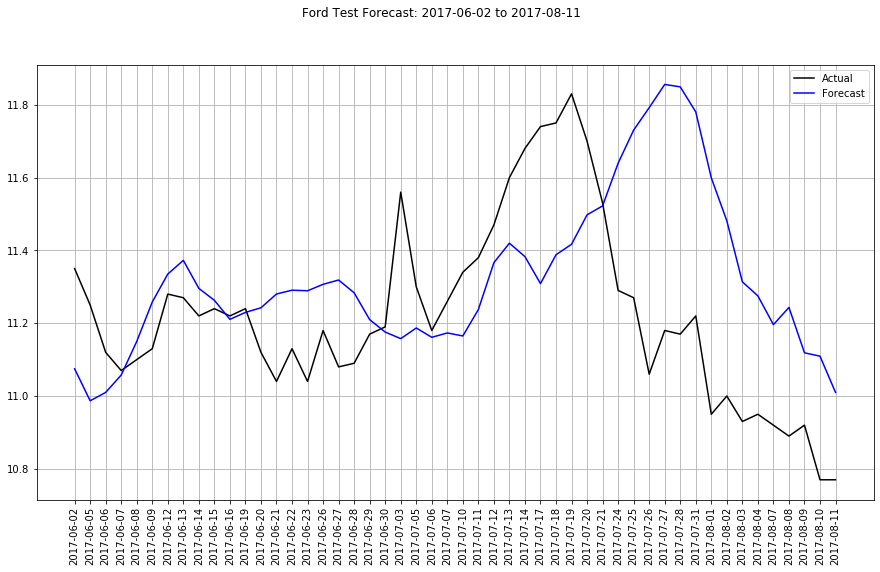

In [150]:
fig, ax = plt.subplots(figsize=(15,8))
plt.suptitle('Ford Test Forecast: ' + str(np.min(validation_df['prediction_date']))[:10] + ' to '+ str(np.max(validation_df['prediction_date']))[:10])
plt.plot(validation_df['prediction_date'] , np.exp(validation_df['outcome']),  color='black', label='Actual')
plt.plot(validation_df['prediction_date'] , np.exp(validation_df['forecast']),  color='blue', label='Forecast')
plt.legend()
plt.grid()
plt.xticks(rotation='vertical')
# ax.xaxis_date()      
#fig.autofmt_xdate()
plt.show()

- As we can see the model does a good job at forecasting the trend but not at predicting the values hence it is not ideal for trading. This is mainly because the forecasted trend seems lag a little during market turns compared to to the real values.

##### Improvements
- The trained model has a loss of 0.19. This is in log format which is 1.04 dollars. The stocks included in our analysis have prices ranging from 1 dollar to over 2000 dollars, therefore it may be better to capture the error loss in percentage so that the value is comparable to other stocks. 

## Forecasting on live stock data

- We will take the stock that we separated out from the dataframe and feed it to the model to see the prediction vs the actual values. We will also plot this to get a more visual understanding between the prediction and actual data.

- It is important to notice that we are only passing the feature data to the model in order to get the 5 days out prediction.


In [151]:
import datetime 
import pandas_datareader as dt

symbol='AAPL'

#last 60 days
start=datetime.datetime.now()
end=datetime.datetime.now()-datetime.timedelta(days=65)

live_stock_data=dt.DataReader(symbol, 'yahoo', end, start)
live_stock_data.reset_index(inplace=True)

live_stock_data.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
41,2020-06-17,355.399994,351.089996,355.149994,351.589996,28532000.0,351.589996
42,2020-06-18,353.450012,349.220001,351.410004,351.730011,24205100.0,351.730011
43,2020-06-19,356.559998,345.149994,354.640015,349.720001,66119000.0,349.720001
44,2020-06-22,359.459991,351.149994,351.339996,358.869995,33719700.0,358.869995
45,2020-06-23,372.369995,362.276703,364.000000,366.529999,52318641.0,366.529999


In [152]:
# prepare the live data for forecasting - log tranform it 
live_stock_data = live_stock_data[[ 'Date', 'Close']]

# make data model ready

#log transform it
live_stock_data['Close'] = np.log(live_stock_data['Close'])

# sort by ascending dates as we've done in training 
live_stock_data = live_stock_data.sort_values('Date')
live_stock_data.head()

,Date,Close
0,2020-04-20,5.623765
1,2020-04-21,5.592367
2,2020-04-22,5.620763
3,2020-04-23,5.616880
4,2020-04-24,5.645341


In [153]:
#building the dataset as we did before 
X = []

prediction_dates = []
last_market_dates = []

rolling_period=10
predict_out_period=5

for per in range(rolling_period,len(live_stock_data)):
    X_tmp=[]
    for rollper in range(per-rolling_period,per):
        #populate the values in X_tmp
        X_tmp+=[live_stock_data['Close'].values[rollper]]
    
    X.append(np.array(X_tmp))
    
    #append the last market dates and prediction dates
    prediction_dates.append(live_stock_data['Date'].values[per] + 
                             np.timedelta64(predict_out_period,'D'))
    
    last_market_dates.append(live_stock_data['Date'].values[per])
    

live_stock_ready_df = pd.DataFrame(X)



live_stock_ready_df['prediction_date'] = prediction_dates
live_stock_ready_df['last_market_date'] = last_market_dates



In [154]:
live_stock_ready_df.tail()

,0,1,2,3,4,5,6,7,8,9,prediction_date,last_market_date
31,5.784194,5.775545,5.803628,5.809523,5.840613,5.866015,5.816813,5.825410,5.837701,5.863858,2020-06-22,2020-06-17
32,5.775545,5.803628,5.809523,5.840613,5.866015,5.816813,5.825410,5.837701,5.863858,5.862466,2020-06-23,2020-06-18
33,5.803628,5.809523,5.840613,5.866015,5.816813,5.825410,5.837701,5.863858,5.862466,5.862864,2020-06-24,2020-06-19
34,5.809523,5.840613,5.866015,5.816813,5.825410,5.837701,5.863858,5.862466,5.862864,5.857133,2020-06-27,2020-06-22
35,5.840613,5.866015,5.816813,5.825410,5.837701,5.863858,5.862466,5.862864,5.857133,5.882960,2020-06-28,2020-06-23


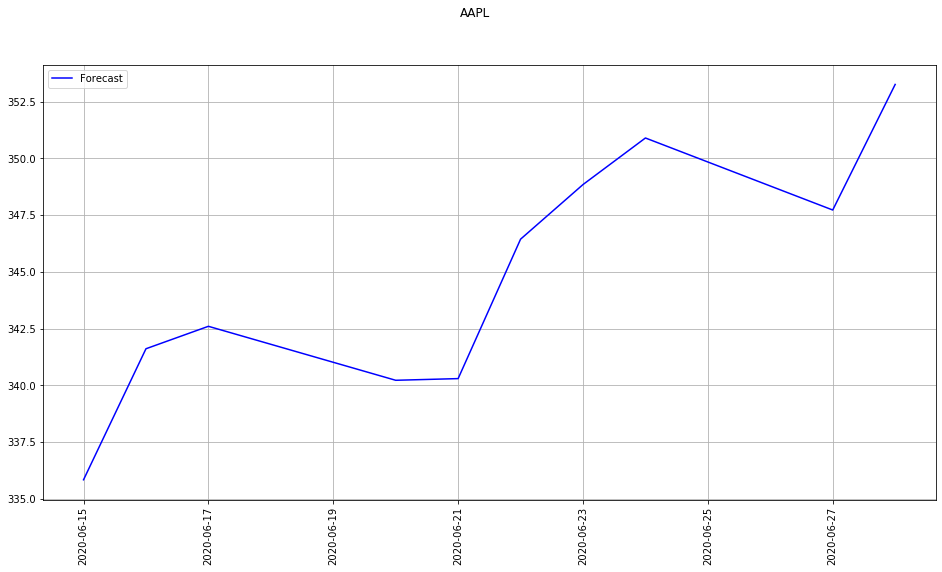

In [155]:
# forecast on live data (basically the last x days where we don't have an outcome...)

#pass the feature values to trained model and get predictions
predictions = loaded_model.predict(live_stock_ready_df[MODEL_FEATURES])

forecast_list=[]
#change prediction values to numpy array
predictions=np.array(predictions)
#flatten the numpy array
predictions=predictions.flatten()

#append to empty list
for value in predictions:
    forecast_list.append(value)


# live_stock_ready_df = validation_tmp.copy()
live_stock_ready_df['forecast'] = np.exp(forecast_list)

live_stock_ready_df = live_stock_ready_df.tail(10)


fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle('AAPL')
plt.plot(live_stock_ready_df['prediction_date'], live_stock_ready_df['forecast'], color='blue', label='Forecast')
plt.legend()
plt.grid()
plt.xticks(rotation='vertical')
plt.show()

([<matplotlib.axis.XTick at 0x19c57588>,
 <a list of 14 Text xticklabel objects>)

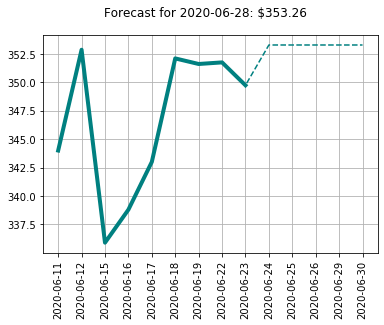

In [156]:
#get the last 9 historical readings from dataset
actuals = list(live_stock_ready_df.tail(1).values[0])[0:rolling_period-1]
# transform log price to price of past data
actuals = list(np.exp(actuals))

#get the last historical date reading
days_before = live_stock_ready_df['last_market_date'].values[-1]

#loop and add previous dates to list from the last_market_date date
#using the iterables to guide how many days backwards to add 
days_before_list = []
for d in range(rolling_period-1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),-d, roll='backward')))
    days_before_list.sort()

plt.plot(days_before_list, actuals, color='teal', linewidth=4)

#loop and add to the forecasted dates to existing list from the last_market_date date
#using the iterables to guide how many dates forward to add 
#append only the last forecasted value from the model predictions to actuals as a continuation
for d in range(1, predict_out_period+1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),d, roll='forward')))
    actuals.append(live_stock_ready_df['forecast'].values[-1])
     

plt.suptitle('Forecast for ' + str(live_stock_ready_df['prediction_date'].values[-1])[0:10] + ': $' + str(np.round(live_stock_ready_df['forecast'].values[-1],2)))
plt.plot(days_before_list, actuals, color='teal', linestyle='dashed')
plt.grid()
plt.xticks(days_before_list, days_before_list, rotation='vertical')

# Displaying findings on the web 


### Rest API's

- The goal is to pass any stock symbol and to receive the 5 day forecast. We can do this through using a rest api.

- A Rest API is very simple way to get functions running on the web. These functions rest on the web until someone calls them.


- A rest api uses commands such as get, post, delete, update... and passes the data on top the HTTP protocol. This allows us to use the tech that is mainly used for rendering webpages to carry out calculations.

- We can use Rest APIs to make advanced predictive analytics and even run machine learning algorithms.

- One way to simply run these predictive analytics is by using class function. We can place the function which gets the 5 days stock forecast within the class function and add it to the API resource; every time we call that function and pass a specific query from the web, we will receive the output value of that function dynamically.




### Using HTML to report forecasts visually


-  We can display the final chart displayed on this notebook dynamycally on html. We would have to put all the code we used on this notebook into simple function save it as a python file. 


- Using flaskapp we can tie the html file and python file together and display the findings live dynamically upon request



## Extra stock info

In [157]:
# load nasdaq corollary material
stock_company_info_amex = None
stock_company_info_nasdaq = None
stock_company_info_nyse = None

def load_fundamental_company_info():
    global stock_company_info_amex, stock_company_info_nasdaq, stock_company_info_nyse
    import pandas as pd
    stock_company_info_amex = pd.read_csv('stock_company_info_amex.csv')
    
    stock_company_info_nasdaq = pd.read_csv('stock_company_info_nasdaq.csv')
    
    stock_company_info_nyse = pd.read_csv('stock_company_info_nyse.csv')
    
load_fundamental_company_info()

In [158]:
stock_company_info_amex.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,XXII,"22nd Century Group, Inc",2.81,3.494935e+08,NaN,NaN,Consumer Non-Durables,Farming/Seeds/Milling,https://www.nasdaq.com/symbol/xxii,NaN
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,4.14,1.042994e+09,NaN,1986.0,NaN,NaN,https://www.nasdaq.com/symbol/fax,NaN
2,IAF,Aberdeen Australia Equity Fund Inc,6.05,1.375911e+08,NaN,NaN,NaN,NaN,https://www.nasdaq.com/symbol/iaf,NaN
3,AEF,"Aberdeen Emerging Markets Equity Income Fund, ...",6.83,4.132084e+08,NaN,NaN,NaN,NaN,https://www.nasdaq.com/symbol/aef,NaN
4,FCO,"Aberdeen Global Income Fund, Inc.",8.42,7.346272e+07,NaN,1992.0,NaN,NaN,https://www.nasdaq.com/symbol/fco,NaN


In [159]:
def get_fundamental_information(symbol):
    CompanyName = "No company name"
    Sector = "No sector"
    Industry = "No industry"
    MarketCap = "No market cap"
    Exchange = 'No exchange'
    
    if (symbol in list(stock_company_info_nasdaq['Symbol'])):
        data_row = stock_company_info_nasdaq[stock_company_info_nasdaq['Symbol'] == symbol]  
        CompanyName = data_row['Name'].values[0]
        Sector = data_row['Sector'].values[0]
        Industry = data_row['Industry'].values[0]
        MarketCap = data_row['MarketCap'].values[0]
        Exchange = 'NASDAQ'
        
    elif (symbol in list(stock_company_info_amex['Symbol'])):
        data_row = stock_company_info_amex[stock_company_info_amex['Symbol'] == symbol]  
        CompanyName = data_row['Name'].values[0]
        Sector = data_row['Sector'].values[0]
        Industry = data_row['Industry'].values[0]
        MarketCap = data_row['MarketCap'].values[0]
        Exchange = 'AMEX'
 
    elif (symbol in list(stock_company_info_nyse['Symbol'])):
        data_row = stock_company_info_nyse[stock_company_info_nyse['Symbol'] == symbol]  
        CompanyName = data_row['Name'].values[0]
        Sector = data_row['Sector'].values[0]
        Industry = data_row['Industry'].values[0]
        MarketCap = data_row['MarketCap'].values[0]
        Exchange = 'NYSE'
 
    return (CompanyName, Sector, Industry, MarketCap, Exchange)

fundamentals = get_fundamental_information('MSFT')
fundamentals


('Microsoft Corporation',
 'Technology',
 'Computer Software: Prepackaged Software',
 856539874197.2,
 'NASDAQ')

In [160]:
def get_wikipedia_intro(symbol):
    import wikipedia
    company_name = get_fundamental_information(symbol)[0]
    description = wikipedia.page(company_name).content
    return(description.split('\n')[0])

get_wikipedia_intro('AAPL')

"Apple Inc. is an American multinational technology company headquartered in Cupertino, California, that designs, develops, and sells consumer electronics, computer software, and online services. It is considered one of the Big Tech technology companies, alongside Amazon, Google, Microsoft and Facebook.The company's hardware products include the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the iPod portable media player, the Apple Watch smartwatch, the Apple TV digital media player, the AirPods wireless earbuds and the HomePod smart speaker. Apple's software includes macOS, iOS, iPadOS, watchOS, and tvOS operating systems, the iTunes media player, the Safari web browser, the Shazam music identifier, and the iLife and iWork creativity and productivity suites, as well as professional applications like Final Cut Pro, Logic Pro, and Xcode. Its online services include the iTunes Store, the iOS App Store, Mac App Store, Apple Music, Apple TV+, iMessage, and iCloud.

In [161]:
stock_market_live_data = []
for stock in stock_symbols:
    print(stock)
    stock_data = stocks_df[stocks_df['Name']==stock].copy()
    # get only the last rolling_period 
    stock_data = stock_data.tail(rolling_period)

    no_outcome_id = len(stock_data)-predict_out_period
    future_data = []
    future_dates = []
    last_market_dates = []
    # shift everything out into 'no outcome' zone
    for per in range(no_outcome_id+1, len(stock_data)+1): 
        X_tmp = []
        y_tmp = 0
        for rollper in range(per-rolling_period,per):
            X_tmp +=[ np.log(stock_data['close'].values[rollper])]

        future_data.append(np.array(X_tmp))
        last_market_dates.append(stock_data['date'].values[rollper])
        # create a business day offset for future dates to avoid weekends and holidays 
        future_date = np.busday_offset(np.datetime64(stock_data['date'].values[rollper],'D'),predict_out_period, roll='forward')
    
    stock_market_live_data.append(X_tmp + [-1] + [str(future_date)] + [stock_data['date'].values[rollper]] + [stock])
   
stock_market_live_data = pd.DataFrame(stock_market_live_data)
stock_market_historical_data = pd.read_csv('stock_market_historical_data.csv')
stock_market_live_data.columns = list(stock_market_historical_data)
# write a copy to file to use in our web application
stock_market_live_data.to_csv('stock_market_live_data.csv', index=None)


ATVI
HRS
VLO
ES
DUK
JNJ
MDLZ
MAS
PEP
ADI
LUV
NYSE:LMT
ALLE
PCG
BAC
NSC
L
HBAN
COG
SIG
INTC
GOOGL
FTV
MCHP
MRK
CAH
WU
MMM
CB
FAST
SNPS
MNST
O
AFL
VNO
CVS
AIZ
FB
MHK
FOXA
TJX
WYNN
ECL
SYF
CNC
AEP
UAA
ABC
GS
WM
SBUX
ACN
ADS
OKE
FFIV
LH
MSI
GOOG
MYL
PX
STI
EW
ALL
BRK.B
PSX
ALGN
COTY
TSCO
JBHT
NAVI
YUM
FTI
DISCA
HIG
NUE
ILMN
CCL
COF
FLS
PM
HCN
TGT
EVHC
DFS
BSX
MCK
BXP
CHRW
ETR
ISRG
APH
BAX
JNPR
K
FRT
HOG
CA
HRL
PPG
AAPL
LUK
NWSA
DVN
GT
APD
IT
DTE
AZO
CME
LNC
DGX
LEG
WMT
AIG
ANTM
MU
NVDA
TIF
AON
ARE
LOW
M
PEG
LEN
KO
CHK
PGR
MDT
FLR
MS
AET
EXPE
COL
FBHS
GLW
EMR
WHR
DPS
IRM
PWR
NEE
SWKS
HUM
VRTX
KEY
PDCO
KMB
CSX
PYPL
BA
BLL
IVZ
VZ
BIIB
CTL
PFE
TSN
VRSK
VMC
CSCO
ABT
GWW
CVX
MAA
XL
PCAR
XLNX
CTXS
EXR
AMGN
GGP
NOV
AOS
AWK
BHF
IBM
CFG
D
SLG
VTR
KMI
BWA
UPS
FL
AJG
MO
KMX
NTAP
AGN
NFX
INFO
HP
PFG
EXC
JPM
PHM
CNP
UNP
DAL
CMS
MTB
EQT
RF
ADM
UNH
USB
EBAY
EIX
ALB
FMC
HON
UA
IPG
FITB
WFC
RMD
RJF
HCP
ROST
BCR
DXC
SYMC
HAS
PAYX
MGM
AVY
DLPH
MLM
IDXX
ZTS
PBCT
FDX
SLB
BBT
STZ
HST
MCO
PVH
COST
ROP
QCOM
ADBE
G

In [162]:



def GetLiveStockData(symbol, size=50):
    # we'll use pandas_datareader
    import datetime
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web

    try:
        end = datetime.datetime.now()
        start = datetime.datetime.now() - datetime.timedelta(days=60)
        live_stock_data = web.DataReader(symbol, 'yahoo', start, end)
        live_stock_data.reset_index(inplace=True)
        live_stock_data = live_stock_data[[ 'Date', 'Adj Close']]
        # live_stock_data = live_stock_data[['symbol', 'begins_at', 'close_price']]
        # live_stock_data.columns = ['symbol', 'date', 'close']
    except:
        live_stock_data = None

    if (live_stock_data is not None):
        live_stock_data = live_stock_data.sort_values('Date')
        live_stock_data = live_stock_data.tail(size)

        # make data model ready
        #live_stock_data['Close'] = pd.to_numeric(live_stock_data['Close'], errors='coerce')
        live_stock_data['Adj Close'] = np.log(live_stock_data['Adj Close'])

        # clean up the data so it aligns with our earlier notation
        #live_stock_data['date'] = pd.to_datetime(live_stock_data['date'], format = '%m/%d/%y')
        # sort by ascending dates as we've done in training
        live_stock_data = live_stock_data.sort_values('Date')

        # build dataset
        X = []

        prediction_dates = []
        last_market_dates = []

        # rolling predictions
        rolling_period = 10
        predict_out_period = 5

        for per in range(rolling_period, len(live_stock_data)):
            X_tmp = []
            for rollper in range(per-rolling_period,per):
                # build the 'features'
                X_tmp += [live_stock_data['Adj Close'].values[rollper]]

            X.append(np.array(X_tmp))

            # add x days to last market date using numpy timedelta64
            prediction_dates.append(live_stock_data['Date'].values[per] + np.timedelta64(predict_out_period,'D'))
            last_market_dates.append(live_stock_data['Date'].values[per])


        live_stock_ready_df = pd.DataFrame(X)
        live_stock_ready_df.columns = [str(f) for f in list(live_stock_ready_df)]

        live_stock_ready_df['prediction_date'] = prediction_dates
        live_stock_ready_df['last_market_date'] = last_market_dates

        # live_stock_ready_df.columns = [str(f) for f in live_stock_ready_df]

        return(live_stock_ready_df)
    else:
        return(None)

In [163]:
r=GetLiveStockData('AAPL', size=50)
r

,0,1,2,3,4,5,6,7,8,9,prediction_date,last_market_date
0,5.643344,5.627002,5.659319,5.680196,5.663966,5.678015,5.692913,5.703177,5.713469,5.736992,2020-05-16,2020-05-11
1,5.627002,5.659319,5.680196,5.663966,5.678015,5.692913,5.703177,5.713469,5.736992,5.752604,2020-05-17,2020-05-12
2,5.659319,5.680196,5.663966,5.678015,5.692913,5.703177,5.713469,5.736992,5.752604,5.741110,2020-05-18,2020-05-13
3,5.680196,5.663966,5.678015,5.692913,5.703177,5.713469,5.736992,5.752604,5.741110,5.728963,2020-05-19,2020-05-14
4,5.663966,5.678015,5.692913,5.703177,5.713469,5.736992,5.752604,5.741110,5.728963,5.735087,2020-05-20,2020-05-15
5,5.678015,5.692913,5.703177,5.713469,5.736992,5.752604,5.741110,5.728963,5.735087,5.729158,2020-05-23,2020-05-18
6,5.692913,5.703177,5.713469,5.736992,5.752604,5.741110,5.728963,5.735087,5.729158,5.752446,2020-05-24,2020-05-19
7,5.703177,5.713469,5.736992,5.752604,5.741110,5.728963,5.735087,5.729158,5.752446,5.746650,2020-05-25,2020-05-20
8,5.713469,5.736992,5.752604,5.741110,5.728963,5.735087,5.729158,5.752446,5.746650,5.765912,2020-05-26,2020-05-21
9,5.736992,5.752604,5.741110,5.728963,5.735087,5.729158,5.752446,5.746650,5.765912,5.758428,2020-05-27,2020-05-22
